# Context
The data was collected from an apartment unit in San Jose for one plus year of one of Kaggle's community members. The collection was done with smart meters and shared by his energy company. This is time-series data by nature and can be used for various time-series Machine Learning experiments.

## Description of Data
The data contains eight attributes.

- TYPE - This is an information column. The value is 'Electric usage' for all the observations.
- DATE - Date of electric consumption. There is no timestamp in this field.
- START TIME - Start time of the consumption.
- END TIME - End time of the consumption
- USAGE - Consumption in kWh
- UNITS - This column denotes measurement unit. It is kWh for all the observations.
- COST - Cost of consumption in $.
- NOTES - Mostly an empty column

# Setting the environment and loading data 

In [1]:
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
data= pd.read_csv("../IOTTimeSeries/Data/D202.csv", parse_dates=True)
data.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


# EDA 

## Data Exploration

In [3]:
#data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


We notice columns that we can promptly delete as unnecessary to our analysis, along with Notes columns which holds no information.

For this specific dataset we have no missing values. 

In [22]:
#duplicates

duplicates= data.duplicated()
duplicates.sum()

0

## Data prep

In [48]:
#timestamp column creation 
add_prefix_lambda = lambda start_time: "0"+ start_time if int(start_time.split(":")[0]) < 12 else start_time
data["START TIME"] = data["START TIME"].apply(add_prefix_lambda)

data["timestamp"] = data["DATE"] + " " + data["START TIME"]
data["timestamp"] = pd.to_datetime(data["timestamp"])

In [46]:
data.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES,timestamp
0,Electric usage,10/22/2016,00:00,0:14,0.01,kWh,$0.00,NaN,2016-10-22 00:00:00
1,Electric usage,10/22/2016,00:15,0:29,0.01,kWh,$0.00,NaN,2016-10-22 00:15:00
2,Electric usage,10/22/2016,00:30,0:44,0.01,kWh,$0.00,NaN,2016-10-22 00:30:00
3,Electric usage,10/22/2016,00:45,0:59,0.01,kWh,$0.00,NaN,2016-10-22 00:45:00
4,Electric usage,10/22/2016,01:00,1:14,0.01,kWh,$0.00,NaN,2016-10-22 01:00:00


In [65]:
df = data[["timestamp", "USAGE"]]
df.columns = ["timestamp", "usage"]
df.set_index("timestamp")

,usage
timestamp,
2016-10-22 00:00:00,0.01
2016-10-22 00:15:00,0.01
2016-10-22 00:30:00,0.01
2016-10-22 00:45:00,0.01
2016-10-22 01:00:00,0.01
...,...
2018-10-24 22:45:00,0.02
2018-10-24 23:00:00,0.03
2018-10-24 23:15:00,0.03


In [66]:
df.head()

,timestamp,usage
0,2016-10-22 00:00:00,0.01
1,2016-10-22 00:15:00,0.01
2,2016-10-22 00:30:00,0.01
3,2016-10-22 00:45:00,0.01
4,2016-10-22 01:00:00,0.01


In [74]:
#hourly
hourly_usage = df.set_index('timestamp').resample('1h').sum()

# Daily
daily_usage = hourly_usage.resample("1D").sum()

# Monthly
monthly_usage= daily_usage.resample("1M").sum()


In [76]:
monthly_usage.head()

,usage
timestamp,
2016-10-31,85.60
2016-11-30,404.36
2016-12-31,624.52
2017-01-31,742.40
2017-02-28,458.12


## Visualization

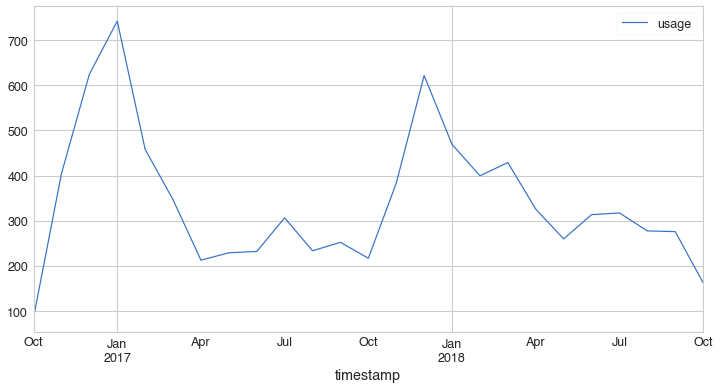

In [81]:
fig, ax = plt.subplots(figsize=(12,6))
monthly_usage.plot(ax=ax)
plt.show()

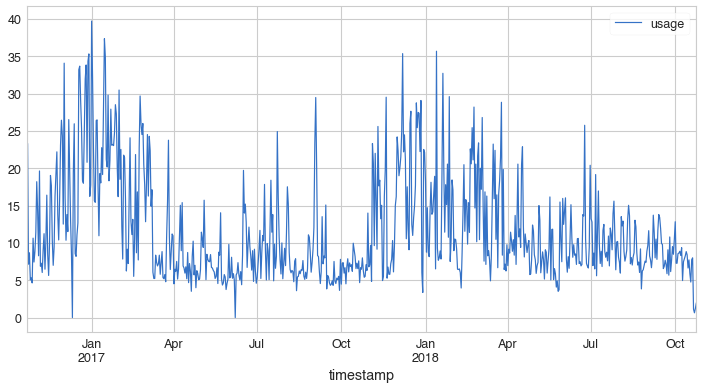

In [80]:
fig, ax = plt.subplots(figsize=(12,6))

daily_usage.plot(ax=ax)
plt.show()

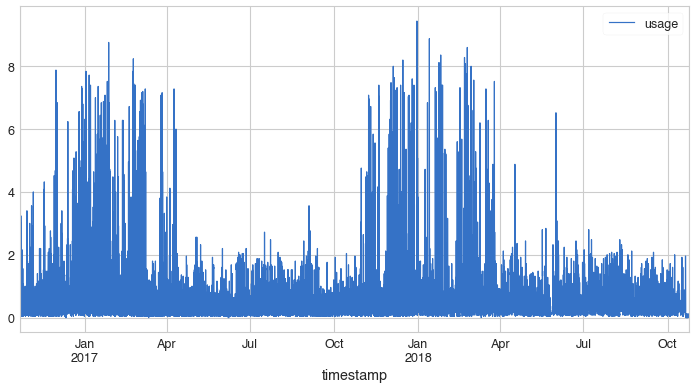

In [82]:
fig, ax = plt.subplots(figsize=(12,6))

hourly_usage.plot(ax=ax)
plt.show()